# Visualize interactively AIM images using the k3d library

This notebook is intended to guide you through the process of visualizing and apply basic image processing operations to the AIM images loaded via the ``vtkbone`` library.
As the ``vtkbone`` library is meant for IO operations, a visualization package is outside of the scope of the library. However, we provide informations on the usage of a compatible library, ``k3d``, which integrate seamlessly with the vtk image data structure.

## Step 1: Import necessary packages

In [41]:
import functools
from pathlib import Path

import k3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import vtk
from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy

import vtkbone

### Get the k3d package if not already installed

In [42]:
%pip install k3d

Note: you may need to restart the kernel to use updated packages.


## Step 2: Read the image using ``vtkbone``

In [43]:
# Give the path to your AIM file
impath = Path('../../IMG1237.AIM')

We first read the 3D image from an AIM file using the ``vtkboneAIMReader``. The read_image function is decorated with ``@print_image_info`` to print the image's properties (spacing, origin, dimensions, byte format) upon reading.

In [44]:
# decorator that print informations such as spacing, origin, dimensions, byte format
def print_image_info(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        image = func(*args, **kwargs)
        spacing = image.GetSpacing()
        origin = image.GetOrigin()
        dimensions = image.GetDimensions()
        byte_format = image.GetScalarTypeAsString()

        print("Image Informations:")
        print(f"Spacing: {np.round(spacing, 3)}")
        print(f"Origin: {np.round(origin, 3)}")
        print(f"Dimensions: {dimensions}")
        print(f"Byte Format: {byte_format}")

        return image
    
    return wrapper

We then define and apply the function ``read_image()`` to read the image from the AIM file.

In [45]:
@print_image_info
def read_image(aim_path: Path):
    """
    Read a 3D image from a file using the vtkboneAIMReader to read a 3D image from a file in the AIM format. 

    Parameters:
    aim_path (Path): The path to the AIM file to read.

    Returns:
    vtkImageData: The 3D image read from the file.
    """
    print(f'Reading file: {aim_path}')
    reader = vtkbone.vtkboneAIMReader()
    reader.DataOnCellsOff()
    reader.SetFileName(str(aim_path.resolve()))
    reader.Update()
    return reader.GetOutput()

# execute the function
image = read_image(impath)

Reading file: ../../IMG1237.AIM
Image Informations:
Spacing: [0.061 0.061 0.061]
Origin: [6.4918e+01 3.2869e+01 3.0000e-02]
Dimensions: (408, 516, 168)
Byte Format: short


## Step 3: Visualize the image using ``k3d``
### Step 3.1: Convert the image to a numpy array

In this conversion step, we return a numpy array containing the informations of the image. VTK images are indexed in the order [x, y, z], while numpy array are indexed in the opposite order [z, y, x]. We therefore need to reverse the order of the dimensions of the image.

In [46]:
def imvtk_to_numpy(image):
    """
    Convert a vtkImageData object to a numpy array.

    This function takes a vtkImageData object, extracts its point data, and reshapes it to match the image dimensions. 
    The resulting numpy array is then transposed and flipped along the z-axis to match the orientation of the original AIM image.

    Parameters:
    image (vtkImageData): The vtkImageData object to convert.

    Returns:
    numpy.ndarray: The converted numpy array.
    """
    image_data = image.GetPointData().GetScalars()
    im_np = vtk_to_numpy(image_data)
    im_np_r = im_np.reshape(image.GetDimensions(), order='F')
    im_np_t = np.transpose(im_np_r, (2, 1, 0))
    im_np_f = np.flip(im_np_t, axis=2)
    return im_np_f.astype(np.float16)

imnp = imvtk_to_numpy(image)

### Step 3.2: Get information about the image for visualization

We then want to include some image information in the visualization. We therefore get the spacing, origin, and dimensions of the image to create a transformation matrix that will be used to correctly position the image in the visualization.

In [47]:
def __get_im_informations__(image):
    """
    Extract spacing, origin, and dimensions from a vtkImageData object.

    This function takes a vtkImageData object and extracts its spacing, origin, and dimensions. 
    These are important properties that describe the physical size, position, and resolution of the image.

    Parameters:
    image (vtkImageData): The vtkImageData object to extract information from.

    Returns:
    tuple: A tuple containing the spacing, origin, and dimensions of the image. 
        Spacing and origin are tuples of three floats, and dimensions is a tuple of three integers.
    """
    spacing = image.GetSpacing()
    origin = image.GetOrigin()
    dimensions = image.GetDimensions()
    return spacing, origin, dimensions

def __get_transformation_matrix__(spacing: list, origin: list, dimensions: list):
    """
    Generate a transformation matrix for a 3D image.

    This function takes the spacing, origin, and dimensions of a 3D image and generates a transformation matrix. 
    This matrix can be used to transform the voxel coordinates of the image to world coordinates.

    Parameters:
    spacing (tuple): The spacing of the image (mm).
    origin (tuple): The origin of the image (mm).
    dimensions (tuple): The dimensions of the image (-).

    Returns:
    numpy.ndarray: A 4x4 transformation matrix.
    """
    transform_matrix = np.array([
        [spacing[0] * dimensions[0], 0, 0, origin[0]],
        [0, spacing[1] * dimensions[1], 0, origin[1]],
        [0, 0, spacing[2] * dimensions[2], origin[2]],
        [0, 0, 0, 1]
    ])
    return transform_matrix

def __get_vmin_vmax__(imnp: np.ndarray):
    """
    Calculate the minimum and maximum intensity values for an image.

    This function takes a numpy array representing an image and calculates the minimum and maximum intensity values 
    for that image. These values can be used for setting the intensity range when visualizing the image.

    If the maximum intensity is greater than 1, the minimum intensity is set to 0.01. If the maximum intensity is 
    greater than 127, the minimum intensity is set to 3000, assuming the image is likely a greyscale image and 
    removing the soft tissue.

    Parameters:
    imnp (numpy.ndarray): The numpy array representing the image.

    Returns:
    tuple: A tuple containing the minimum and maximum intensity values (vmin, vmax).
    """
    intensity_min = np.min(imnp)
    intensity_max = np.max(imnp)
    
    if intensity_max > 1:
        vmin = 0.01
        if intensity_max > 127:
            vmin = 3000
    vmax = intensity_max
    return vmin, vmax

### Step 3.3: Create the visualization

In [55]:
# Get the spacing, origin, and dimensions from the vtk image
spacing, origin, dimensions = __get_im_informations__(image)
# Get the transformation matrix that transforms numpy coordinates to world coordinates
transform_matrix = __get_transformation_matrix__(spacing, origin, dimensions)
# Get the minimum and maximum values of the image in order to set the default threshold range in the visualization
vmin, vmax = __get_vmin_vmax__(imnp)

transform_s = k3d.transform(custom_matrix=transform_matrix)

# Instantiate the volume plot using k3d-jupyter
plt_volume = k3d.volume(imnp,
                        transform=transform_s,
                        color_map=k3d.colormaps.basic_color_maps.Binary,
                        samples=256,
                        alpha_coef=150,
                        color_range=[vmin, vmax])
plot = k3d.plot()
plot += plt_volume
# Display the plot inline
plot.display()

Output()

# Visualize AIM image slices using the matplotlib library

Matplotlib is a powerful library for creating static, animated, and interactive visualizations in Python. Here's how you can use it to visualize slices of an AIM image. Assume you have a 3D numpy array image representing your AIM image. You can get slices of this image like so:

In [49]:
slice1 = imnp[50, :, :]  # Slice at index 50 along the x-axis
slice2 = imnp[:, 100, :]  # Slice at index 50 along the y-axis
slice3 = imnp[:, :, 100]  # Slice at index 50 along the z-axis

Now, you can use matplotlib to visualize these slices in 3 rows:

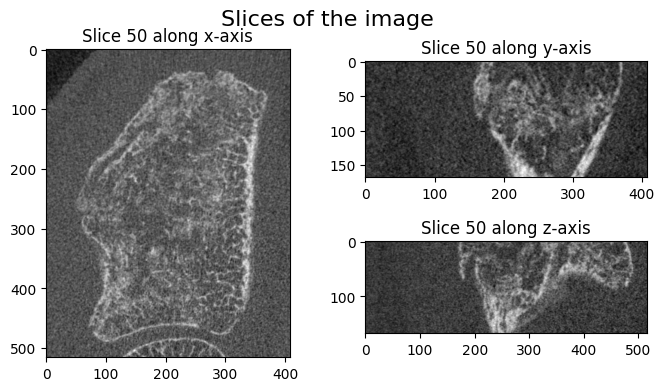

In [56]:
def imshow_2d(imnp: np.ndarray, idx_x: int = 50, idx_y: int = 100, idx_z: int = 100):
    slice1 = imnp[idx_x, :, :]  # Slice at index 50 along the x-axis
    slice2 = imnp[:, idx_y, :]  # Slice at index 50 along the y-axis
    slice3 = imnp[:, :, idx_z]  # Slice at index 50 along the z-axis
    # Create a 2x2 grid
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(8, 4))
    ax0 = fig.add_subplot(gs[:, 0])  # This subplot spans two rows and one column
    ax1 = fig.add_subplot(gs[0, 1])  # This subplot is in the first row and second column
    ax2 = fig.add_subplot(gs[1, 1])  # This subplot is in the second row and second column

    ax0.imshow(slice1, cmap='gray')
    ax1.imshow(slice2, cmap='gray')
    ax2.imshow(slice3, cmap='gray')

    ax0.set_title(f'Slice {_slice_number} along x-axis')
    ax1.set_title(f'Slice {_slice_number} along y-axis')
    ax2.set_title(f'Slice {_slice_number} along z-axis')

    plt.suptitle('Slices of the image', fontsize=16)
    plt.show()
    return None

imshow_2d(imnp)

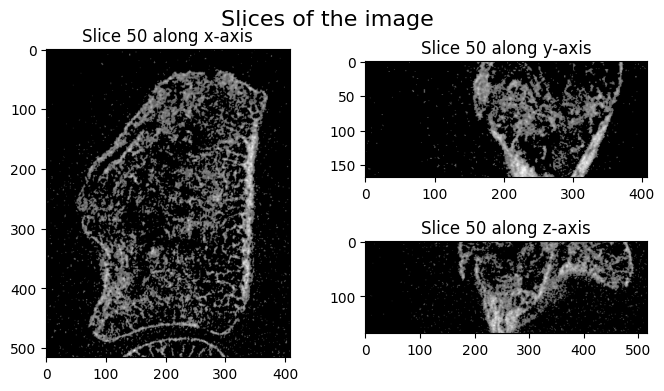

In [54]:
# apply threshold to the numpy array
imnp_threshold = np.where(imnp < 3000, 0, imnp)
imshow_2d(imnp_threshold)

and so on...